# Решение задачи:

Импортируем необходимые библиотеки:

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
import gc

import tensorflow as tf
from keras import backend as K

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import fashion_mnist

Создаём директории для сохранения изображений:

In [ ]:
os.makedirs("dataset/domain_A", exist_ok=True)
os.makedirs("dataset/domain_B", exist_ok=True)

Загружаем **Fashion MNIST** и делим данные на два домена:

In [ ]:
(train_images, train_labels), (_, _) = fashion_mnist.load_data()

class_A_mask = train_labels < 5 #классы 0-4
class_B_mask = train_labels >= 5 #классы 5-9

A_data = train_images[class_A_mask]
B_data = train_images[class_B_mask]

Ограничиваем размер датасета для экономии ресурсов (можно убрать или изменить):

In [ ]:
n1 = min(len(A_data), 1000) #ограничение домена A
n2 = min(len(B_data), 1000) #ограничение домена B

A_data = A_data[:n1]
B_data = B_data[:n2]

Сохраняем изображения на диск как **JPEG** с помощью функции `save_images`. В дальнейшем в коде будем использовать размер **128x128** для экономии ресурсов:

In [ ]:
def save_images(data, directory, prefix):
    for i in range(len(data)):
        img = cv2.resize(data[i], (128, 128), interpolation=cv2.INTER_AREA)
        img_rgb = np.stack([img, img, img], axis=-1) #преобразуем в RGB
        cv2.imwrite(os.path.join(directory, f"{prefix}_{i}.jpg"), img_rgb[:, :, ::-1]) #BGR для cv2

save_images(A_data, "dataset/domain_A", "A")
save_images(B_data, "dataset/domain_B", "B")

Определяем директории и списки файлов:

In [ ]:
dir_A = "dataset/domain_A/"
dir_B = "dataset/domain_B/"

files_A = [f"A_{i}.jpg" for i in range(n1)]
files_B = [f"B_{i}.jpg" for i in range(n2)]

print("Число изображений домена A = ", n1)
print("Число изображений домена B = ", n2)

Число изображений домена A =  1000
Число изображений домена B =  1000


Создаём небольшие массивы для визуализации (36 изображений). `[:, :, ::-1]`: Меняет порядок каналов с BGR на **RGB** (**OpenCV** использует **BGR**, а **TensorFlow** и **Matplotlib** ожидают **RGB**). Это делается путём инверсии последнего измерения (каналов):

In [ ]:
real_A = np.zeros((36, 128, 128, 3), dtype=np.float32)
real_B = np.zeros((36, 128, 128, 3), dtype=np.float32)

for i in range(min(36, n1)):
    real_A[i] = cv2.imread(dir_A + files_A[i])[:, :, ::-1].astype(np.float32) / 127.5 - 1
for i in range(min(36, n2)):
    real_B[i] = cv2.imread(dir_B + files_B[i])[:, :, ::-1].astype(np.float32) / 127.5 - 1

Функция преобразования нормализованного изображения в исходный размер:

In [ ]:
def convert_img(image):
    img2 = ((np.array(image) + 1)*127.5).astype(int) #преобразует входной тензор в массив NumPy, сдвигает значения из [-1, 1] в [0, 255] и приводит к целым числам
    img2[img2 > 255] = 255
    img2[img2 < 0] = 0
    img2 = img2.astype(np.uint8)
    return img2

Отображение 6 изображений в одну линию:

In [ ]:
def plot_line(image, title):
    img2 = ((np.array(image) + 1)*127.5).astype(int)
    img2[img2 > 255] = 255
    img2[img2 < 0] = 0
    fig, ax = plt.subplots(1,6, figsize=(15,2.5))
    N = 6
    for k in range(N):
        ax[k].imshow(img2[k]) #отображает k-е изображение в k-м столбце
        ax[k].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
    ax[0].set_title(title)
    plt.show()

Вызывает сборщик мусора **Python** для освобождения памяти:

In [ ]:
gc.collect()

n2 = 100

Для модели CycleGAN выбрана **InstanceNormalization** вместо **BatchNormalization**, поскольку размер пакета равен всего единице при обучении CycleGAN.

Реализация **InstanceNormalization** описана в [статье](https://arxiv.org/abs/1607.08022). Класс приводится в том виде, как он используется в библиотеке расширений к Tensorflow (TensorFlow Addons). В самой библиотеки наблюдаются на сегодняшний день ошибки, поэтому мы взяли из нее только нужный нам слой.

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        #инициализирует слой с малой константой epsilon для предотвращения деления на ноль
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        #создаёт обучаемые параметры scale и offset для каждого канала входного тензора
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True) #вычисляет среднее и дисперсию по пространственным осям (высота, ширина) для нормализации
        inv = tf.math.rsqrt(variance + self.epsilon) #вычисляет обратный квадратный корень дисперсии с добавлением epsilon для стабильности
        normalized = (x - mean) * inv #нормализует вход, вычитая среднее и деля на стандартное отклонение, затем применяет scale и offset
        return self.scale * normalized + self.offset

`FeatureMapBlock` - это функция извлечения признаков, которая не изменяет размер изображения. Она также используется в конце генератора для улучшения качества генерируемых изображений:

In [ ]:
def FeatureMapBlock(channel, X, final = False):
    if final:
        X = layers.Conv2D(channel, kernel_size = 7, padding = "same", activation = "tanh")(X)
    else:
        X = layers.Conv2D(channel, kernel_size = 7, padding = "same")(X)
        X = InstanceNormalization()(X)
        X = layers.LeakyReLU(alpha=0.2)(X)
    return X

`ContractingBlock` состоит из **Conv2D**, **InstanceNormalization** и функции активации, которая уменьшает размер изображения, как в обычной сверточной сети **CNN**:

In [ ]:
def ContractingBlock(channel, X, relu = True, ksize = 3, use_bn = True):
    X = layers.Conv2D(channel, kernel_size = ksize, strides = 2, padding = "same")(X)
    if use_bn:
        X = InstanceNormalization()(X)
    if relu:
        X = layers.ReLU()(X)
    else:
        X = layers.LeakyReLU(alpha=0.2)(X)
    return X

`ResidualBlock` имеет два уровня **Conv2D** и **InstanceNormalization**. Вход пропускается до конца блока с помощью бокового соединения для устранения проблемы с "мертвым нейроном" (или затухания градиентов):

In [ ]:
def ResidualBlock(channel, X, relu = True):
    X_original = X
    X = layers.Conv2D(channel, kernel_size = 3, padding = "same")(X)
    X = InstanceNormalization()(X)
    if relu:
        X = layers.ReLU()(X)
    else:
        X = layers.LeakyReLU(alpha=0.2)(X)
    X = layers.Conv2D(channel, kernel_size = 3, padding = "same")(X)
    X = InstanceNormalization()(X)
    return X + X_original

`ExandingBlock` состоит из **Conv2DTranspose**, который увеличивает размер изображения. За ним следует функция **InstanceNormalization** и функция активации:

In [ ]:
def ExpandingBlock(channel, X, ksize):
    X = layers.Conv2DTranspose(channel, kernel_size=ksize, strides=2, padding="SAME")(X)
    X = InstanceNormalization()(X)
    X = layers.LeakyReLU(alpha=0.2)(X)
    return X

Генератор состоит из нескольких блоков, которые сначала сжимают изображение, затем проходят через остаточные блоки и, наконец, расширяют изображение до исходного размера:

In [ ]:
def Generator():
    Input = layers.Input(shape=(128, 128, 3))
    channel = 64
    X = FeatureMapBlock(channel, Input, final = False)
    KS = 5
    X = ContractingBlock(channel*2, X, False, KS)  # 64x64
    X = ContractingBlock(channel*4, X, False, KS)  # 32x32
    X = ContractingBlock(channel*8, X, False, KS)  # 16x16
    X = ResidualBlock(channel*8, X, False)
    X = ResidualBlock(channel*8, X, False)
    X = ResidualBlock(channel*8, X, False)
    KS = 5
    X = ExpandingBlock(channel*4, X, KS)  # 32x32
    X = ExpandingBlock(channel*2, X, KS)  # 64x64
    X = ExpandingBlock(channel, X, KS)    # 128x128
    X = FeatureMapBlock(3, X, final = True)
    model = Model(inputs = Input, outputs = X)
    return model

gen_AB = Generator()
gen_BA = Generator()

Дискриминатор оценивает, насколько изображение выглядит как реальное. Он состоит из нескольких сверточных слоев с уменьшением разрешения:

In [ ]:
def Discriminator():
    Input = layers.Input(shape=(128, 128, 3))
    channel = 64
    X = FeatureMapBlock(channel, Input, False)
    X = ContractingBlock(channel*2, X, False, 4)  # 64x64
    X = ContractingBlock(channel*4, X, False, 4)  # 32x32
    X = layers.Conv2D(1, kernel_size = 1, padding = "same")(X)
    model = Model(inputs = Input, outputs = X)
    return model

disc_A = Discriminator()
disc_B = Discriminator()

Определим функцию `get_disc_loss`, которая вычисляет потери дискриминатора, сравнивая предсказания для реальных и сгенерированных изображений. Вычисление потерь осуществляется на основе функции `adv_criterion`, которую мы передаем в качестве параметра в процессе обучения:

In [ ]:
def get_disc_loss(real_pred, fake_pred, adv_criterion):
    #создаёт метки: 1 для реальных изображений, 0 для фейковых
    ones_label = tf.ones_like(real_pred)
    zeros_label = tf.zeros_like(fake_pred)
    disc_loss = (adv_criterion(ones_label, real_pred) + adv_criterion(zeros_label, fake_pred))/2 #вычисляет среднюю потерю дискриминатора, сравнивая предсказания с метками
    return disc_loss

`get_gen_adversarial_loss` вычисляет потери генератора в терминах состязательной части. Генератор пытается обмануть дискриминатор, делая сгенерированные изображения максимально похожими на реальные. Для этого требуется прогнозирование (с помощью дискриминатора) поддельных изображений. В этом случае сравнение происходит с единичной матрицей, как с верным значением. Затем потери рассчитываются на основе `adv_criterion`:

In [ ]:
def get_gen_adversarial_loss(fake_pred, adv_criterion):
    ones_label = tf.ones_like(fake_pred) #создаёт метки 1 для фейковых изображений, чтобы генератор обманывал дискриминатор
    loss = adv_criterion(ones_label, fake_pred) #вычисляет потерю генератора, сравнивая предсказания дискриминатора с метками 1
    return loss

`get_cycle_consistency_loss` - вычисляет потери циклической согласованности. Это потери, которые обеспечивают, что изображение, после преобразования и обратного преобразования, останется похожим на исходное. Для сравнения циклического изображение с исходным используется функция `cycle_criterion`:

In [ ]:
def get_cycle_consistency_loss(real_X, cycle_X, cycle_criterion):
    cycle_loss = cycle_criterion(real_X, cycle_X) #вычисляет потерю циклической согласованности, сравнивая исходное и циклически восстановленное изображение
    return cycle_loss

`get_identity_loss` - вычисляет потери идентичности. Это потери, которые обеспечивают, что изображение, переданное через генератор, будет оставаться похожим на исходное, если оно уже находится в целевом домене. Таким образом вычисляется разницу между исходным изображением и сгенерированным изображением:

In [ ]:
def get_identity_loss(real_X, identity_X, identity_criterion):
    identity_loss = identity_criterion(real_X, identity_X) #вычисляет потерю идентичности, сравнивая исходное изображение с результатом его идентичностного преобразования
    return identity_loss

Зададим оптимизаторы.

Цикл обучения **CycleGAN** подразумевает обучение четырех моделей: генератора **AB** и **BA**, дискриминатора **A** и **B**. Следовательно, необходимо задать четыре оптимизатора. Возьмем оптимизатор **Adam** с шагом *2е-4:*

In [ ]:
optimizer_disc_A = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
optimizer_disc_B = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
optimizer_gen_AB = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
optimizer_gen_BA = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Чтобы отслеживать ход обучения **CycleGAN**, будем сохранять потери в следующих списках.

`loss_discA`. Хранит потери дискриминатора A, который оценивает, насколько изображения из домена A выглядят как реальные.

`loss_discB`. Хранит потери дискриминатора B, который оценивает, насколько изображения из домена B выглядят как реальные.

`loss_gen_AB`. Хранит общие потери генератора AB, который преобразует изображения из домена A в домен B.

`loss_gen_BA`. Хранит общие потери генератора BA, который преобразует изображения из домена B в домен A.

`loss_gen_adv_AB`. Хранит состязательные потери генератора AB, которые отражают, насколько успешно генератор обманывает дискриминатор B.

`loss_gen_adv_BA`. Хранит состязательные потери генератора BA, которые отражают, насколько успешно генератор обманывает дискриминатор A.

`loss_gen_cycle_ABA`. Хранит потери циклической согласованности для генератора AB. Это потери, которые обеспечивают, что изображение, после преобразования из A в B и обратно в A, останется похожим на исходное.

`loss_gen_cycle_BAB`. Хранит потери циклической согласованности для генератора BA. Это потери, которые обеспечивают, что изображение, после преобразования из B в A и обратно в B, останется похожим на исходное.

`loss_gen_iden_AB`. Хранит потери идентичности для генератора AB. Это потери, которые обеспечивают, что изображение, переданное через генератор AB, будет оставаться похожим на исходное, если оно уже находится в целевом домене B.

`loss_gen_iden_BA`. Хранит потери идентичности для генератора BA. Это потери, которые обеспечивают, что изображение, переданное через генератор BA, будет оставаться похожим на исходное, если оно уже находится в целевом домене A.

Эти списки используются для отслеживания и анализа потерь на протяжении всего процесса обучения, что помогает визуализировать и анализировать производительность модели.

In [ ]:
loss_discA = [] #потери дискриминатора A
loss_discB = [] #потери дискриминатора B
loss_gen_AB = [] #общие потери генератора AB
loss_gen_BA = [] #общие потери генератора BA
loss_gen_adv_AB = [] #состязательные потери генератора AB
loss_gen_adv_BA = [] #состязательные потери генератора BA
loss_gen_cycle_ABA = [] #потери циклической согласованности для генератора AB (из A в B и обратно в A)
loss_gen_cycle_BAB = [] #потери циклической согласованности для генератора BA (из B в A и обратно в B)
loss_gen_iden_AB = [] #потери идентичности для генератора AB (из B в B)
loss_gen_iden_BA = [] #потери идентичности для генератора BA (из A в A)

Функции потерь

В случае проигрыша в конкурентной борьбе выбираются бинарная кросс-энтропия или средне-квадратичная ошибка. По другим критериям выбирается средняя-абсолютная ошибка **MAE**:

In [ ]:
#функции потерь для бинарной кросс-энтропии, среднеквадратичной ошибки и средней абсолютной ошибки
BCE_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
MSE_loss = tf.keras.losses.MeanSquaredError()
MAE_loss = tf.keras.losses.MeanAbsoluteError()

adv_loss_function = BCE_loss #состязательная функция потерь

Функция для обучения **CycleGAN**:

Рассмотрим, что делает один шаг обучения:

1. **Инициализация коэффициентов**:
   - `lambda_cycle`, `lambda_identity`, `lambda_adv`: Коэффициенты для взвешивания различных типов потерь.

2. **Обучение дискриминатора A**:
   - **Генерация изображения**: Используя генератор `gen_BA`, создается изображение `fake_A` из `real_B`.
   - **Оценка дискриминатором**: Дискриминатор `disc_A` оценивает `real_A` и `fake_A`.
   - **Вычисление потерь**: Потери дискриминатора A вычисляются с помощью `get_disc_loss`.
   - **Обновление весов**: Веса дискриминатора A обновляются с использованием оптимизатора `optimizer_disc_A`.

3. **Обучение дискриминатора B**:
   - **Генерация изображения**: Используя генератор `gen_AB`, создается изображение `fake_B` из `real_A`.
   - **Оценка дискриминатором**: Дискриминатор `disc_B` оценивает `real_B` и `fake_B`.
   - **Вычисление потерь**: Потери дискриминатора B вычисляются с помощью `get_disc_loss`.
   - **Обновление весов**: Веса дискриминатора B обновляются с использованием оптимизатора `optimizer_disc_B`.

4. **Обучение генераторов**:
   - **Генерация изображений**: Создаются изображения `fake_A` и `fake_B`.
   - **Циклическое восстановление**: Используя генераторы, восстанавливаются изображения `cycle_A` и `cycle_B`.
   - **Идентичность**: Используя генераторы, создаются изображения `iden_B` и `iden_A`.
   - **Оценка дискриминаторами**: Дискриминаторы оценивают сгенерированные изображения.
   - **Вычисление потерь**: Вычисляются состязательные потери, потери циклической согласованности и потери идентичности.
   - **Общие потери генератора**: Общие потери генераторов вычисляются с учетом всех типов потерь.
   - **Обновление весов**: Веса генераторов `gen_AB` и `gen_BA` обновляются с использованием оптимизаторов `optimizer_gen_AB` и `optimizer_gen_BA`.

5. **Очистка памяти**:
   - Удаление временного объекта `GradientTape` и сбор мусора для освобождения памяти.

Этот код реализует один шаг обучения CycleGAN, обновляя веса генераторов и дискриминаторов на основе вычисленных потерь.

In [ ]:
@tf.function
def train_CycleGan(real_A, real_B):
    #коэффициенты для взвешивания потерь
    lambda_cycle = 10 #коэффициент для потерь циклической согласованности
    lambda_identity = 2 #коэффициент для потерь идентичности
    lambda_adv = 1 #коэффициент для состязательных потерь

    #обучение дискриминатора A
    with tf.GradientTape() as tape:
        fake_A = gen_BA(real_B) #генерация изображения домена A из изображения домена B
        real_A_pred = disc_A(real_A) #оценка дискриминатором A истинности реального изображения
        fake_A_pred = disc_A(fake_A) #оценка дискриминатором A фейковости сгенерированного изображения
        disc_loss_A = get_disc_loss(real_A_pred, fake_A_pred, adv_loss_function) #вычисление потерь дискриминатора A

    #обновление весов дискриминатора A
    gradients = tape.gradient(disc_loss_A, disc_A.trainable_weights)
    optimizer_disc_A.apply_gradients(zip(gradients, disc_A.trainable_weights))

    #обучение дискриминатора B
    with tf.GradientTape() as tape:
        fake_B = gen_AB(real_A) #генерация изображения домена B из изображения домена A
        real_B_pred = disc_B(real_B) #оценка дискриминатором B истинности реального изображения
        fake_B_pred = disc_B(fake_B) #оценка дискриминатором B фейковости сгенерированного изображения
        disc_loss_B = get_disc_loss(real_B_pred, fake_B_pred, adv_loss_function) #вычисление потерь дискриминатора B

    #обновление весов дискриминатора B
    gradients = tape.gradient(disc_loss_B, disc_B.trainable_weights)
    optimizer_disc_B.apply_gradients(zip(gradients, disc_B.trainable_weights))

    #обучение генераторов
    with tf.GradientTape(persistent=True) as tape:
        #генерация изображений для обоих доменов
        fake_A = gen_BA(real_B)
        fake_B = gen_AB(real_A)
        #циклическое восстановление изображений (A → B → A и B → A → B)
        cycle_A = gen_BA(fake_B)
        cycle_B = gen_AB(fake_A)
        #идентичностные преобразования (A → A и B → B)
        iden_B = gen_AB(real_B)
        iden_A = gen_BA(real_A)
        #оценка дискриминаторами сгенерированных изображений
        fake_B_pred = disc_B(fake_B)
        fake_A_pred = disc_A(fake_A)
        #состязательные потери генераторов
        gen_adversarial_loss_AB = get_gen_adversarial_loss(fake_B_pred, adv_loss_function)
        gen_adversarial_loss_BA = get_gen_adversarial_loss(fake_A_pred, adv_loss_function)
        #потери циклической согласованности
        cycle_loss_A = get_cycle_consistency_loss(real_A, cycle_A, MAE_loss)
        cycle_loss_B = get_cycle_consistency_loss(real_B, cycle_B, MAE_loss)
        total_cycle_loss = cycle_loss_A + cycle_loss_B
        #потери идентичности
        identity_loss_AB = get_identity_loss(real_B, iden_B, MAE_loss)
        identity_loss_BA = get_identity_loss(real_A, iden_A, MAE_loss)
        #общие потери генераторов
        gen_loss_AB = gen_adversarial_loss_AB * lambda_adv + total_cycle_loss * lambda_cycle + identity_loss_AB * lambda_identity
        gen_loss_BA = gen_adversarial_loss_BA * lambda_adv + total_cycle_loss * lambda_cycle + identity_loss_BA * lambda_identity

    #обновление весов генератора AB
    gradients = tape.gradient(gen_loss_AB, gen_AB.trainable_weights)
    optimizer_gen_AB.apply_gradients(zip(gradients, gen_AB.trainable_weights))

    #обновление весов генератора BA
    gradients = tape.gradient(gen_loss_BA, gen_BA.trainable_weights)
    optimizer_gen_BA.apply_gradients(zip(gradients, gen_BA.trainable_weights))

    #удаление временного объекта GradientTape и сбор мусора для освобождения памяти
    del tape
    gc.collect()

 Функция для чтения изображения из файла:

In [ ]:
def read_img(dir_name, file_name, convert=False):
    img = cv2.imread(dir_name + file_name)[:, :, ::-1] #чтение изображения с использованием OpenCV. `[:,:,::-1]` используется для конвертации из BGR в RGB
    #если установлен флаг convert, изображение масштабируется к диапазону [-1, 1].
    if convert:
        img = img.astype(np.float32) / 127.5 - 1
    return img

Функция для выполнения одной эпохи обучения **CycleGAN**:

In [ ]:
def train_step(EPOCH):
    time1 = time.time() #засекаем время начала эпохи для отслеживания продолжительности
    print("EPOCH ", EPOCH) #выводим номер текущей эпохи для информирования о прогрессе

    count = 0 #инициализируем счётчик обработанных изображений

    np.random.seed(EPOCH) #задаём семя для генератора случайных чисел, чтобы результаты были воспроизводимы

    #создаём массивы индексов для доменов A и B
    m_idx = np.arange(n1) #индексы для домена A (классы 0–4 Fashion MNIST)
    np.random.shuffle(m_idx) #перемешиваем индексы для случайного порядка

    f_idx = np.arange(n2) #индексы для домена B (классы 5–9 Fashion MNIST)
    np.random.shuffle(f_idx) #перемешиваем индексы для случайного порядка

    #цикл по парам изображений из доменов A и B
    for i in range(min(n1, n2)):
        F_data = read_img(dir_B, files_B[f_idx[i]], convert=True) #загружаем и преобразуем изображение из домена B
        M_data2 = read_img(dir_A, files_A[m_idx[i]], convert=True) #загружаем и преобразуем изображение из домена A

        #с вероятностью 50% применяем горизонтальное отражение для аугментации
        if np.random.rand(1)[0] > 0.5:
            train_CycleGan(M_data2[:, ::-1, :].reshape(1, 128, 128, 3), F_data.reshape(1, 128, 128, 3)) #передаём отражённое изображение домена A и изображение домена B в функцию обучения
        else:
            train_CycleGan(M_data2.reshape(1, 128, 128, 3), F_data.reshape(1, 128, 128, 3)) #передаём изображения без аугментации в функцию обучения

        count += 1 #увеличиваем счётчик обработанных изображений
        gc.collect() #освобождаем память, вызывая сборщик мусора

    time2 = time.time()#засекаем время окончания эпохи
    time3 = np.round(time2 - time1) #вычисляем и округляем время выполнения эпохи
    print("time ", time3, "sec, processed images: ", count) #выводим время выполнения и количество обработанных изображений

Визуализирует результаты работы CycleGAN, включая реальные, сгенерированные, циклические и идентичностные изображения:

In [ ]:
def check_output(EPOCH):
    fake_B = gen_AB(real_A) #генерируем изображения домена B из реальных изображений домена A
    fake_A = gen_BA(real_B) #генерируем изображения домена A из реальных изображений домена B
    cycle_A = gen_BA(fake_B) #восстанавливаем изображения домена A из сгенерированных изображений домена B (циклическая согласованность)
    identity_A = gen_BA(real_A) #генерируем изображения домена A из реальных изображений домена A (идентичность)
    cycle_B = gen_AB(fake_A) #восстанавливаем изображения домена B из сгенерированных изображений домена A (циклическая согласованность)
    identity_B = gen_AB(real_B) #генерируем изображения домена B из реальных изображений домена B (идентичность)
    tag = ", epoch " + str(EPOCH) #создаём тег с номером эпохи для заголовков визуализации
    plot_line(real_B, "real_B") #отображаем реальные изображения домена B (классы 5–9 Fashion MNIST)
    plot_line(fake_A, "fake_A " + tag) #отображаем сгенерированные изображения домена A с тегом эпохи
    plot_line(cycle_B, "cycle_B " + tag) #отображаем восстановленные изображения домена B с тегом эпохи
    plot_line(identity_B, "identity_B " + tag) #отображаем идентичностные изображения домена B с тегом эпохи

Функция для обучения **CycleGAN** на заданном количестве эпох:

EPOCH  0
time  120.0 sec, processed images:  100


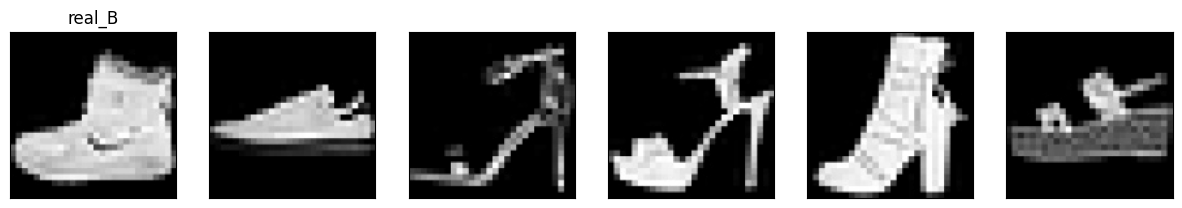

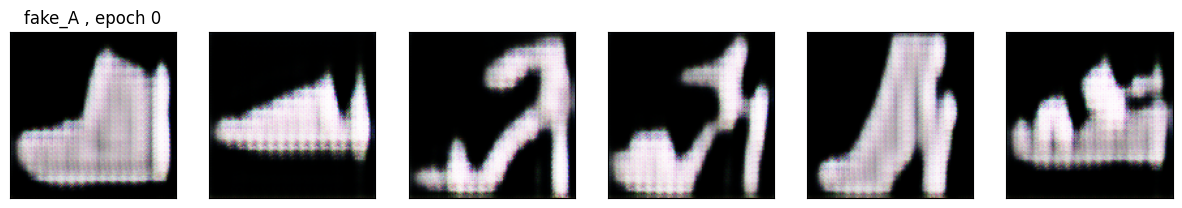

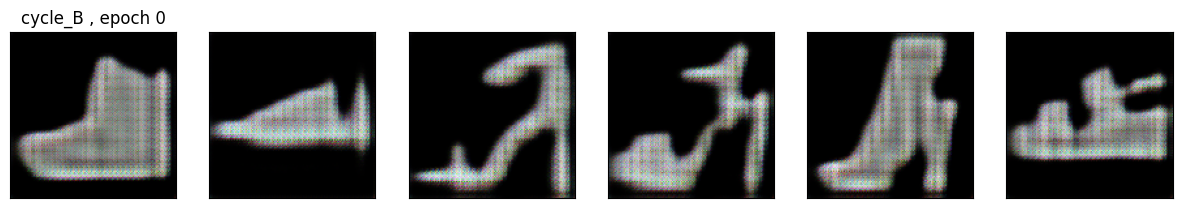

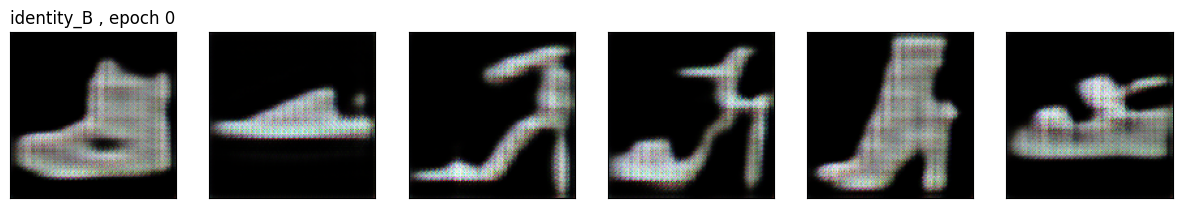

EPOCH  1
time  89.0 sec, processed images:  100
EPOCH  2
time  89.0 sec, processed images:  100
EPOCH  3
time  89.0 sec, processed images:  100
EPOCH  4
time  89.0 sec, processed images:  100
EPOCH  5
time  89.0 sec, processed images:  100


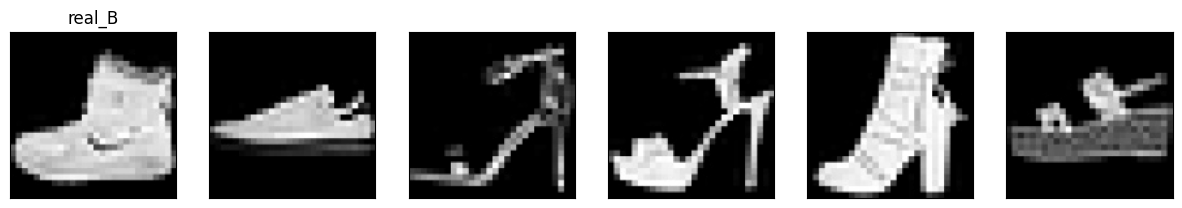

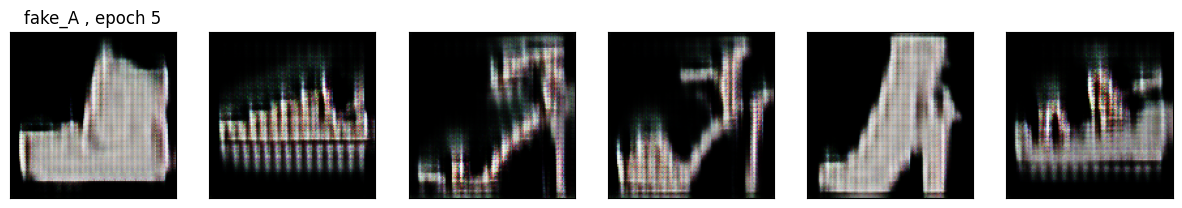

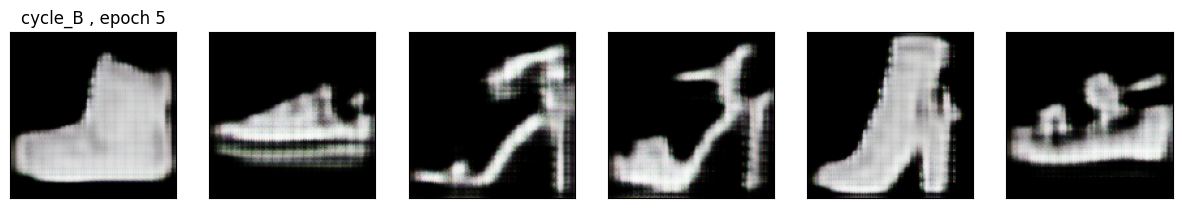

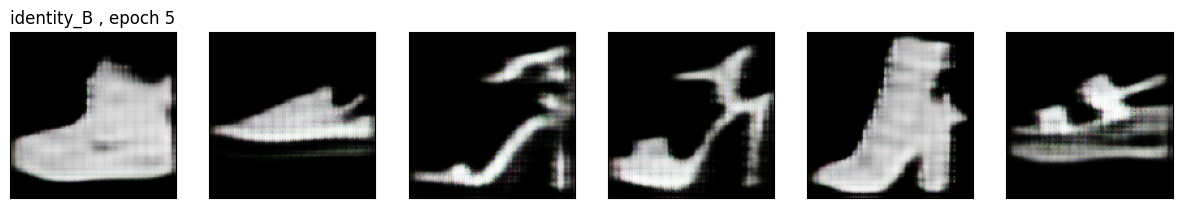

EPOCH  6
time  90.0 sec, processed images:  100
EPOCH  7
time  89.0 sec, processed images:  100
EPOCH  8
time  89.0 sec, processed images:  100
EPOCH  9
time  89.0 sec, processed images:  100
EPOCH  10
time  89.0 sec, processed images:  100


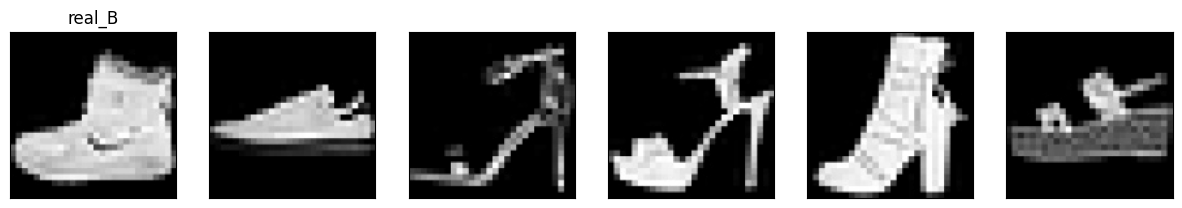

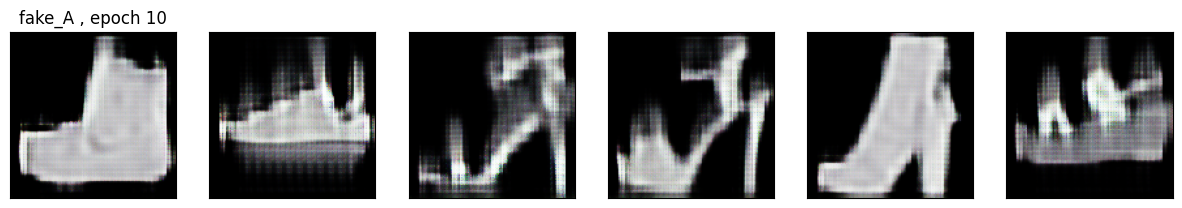

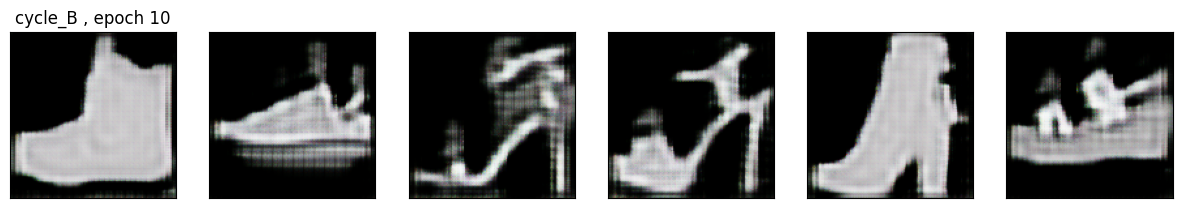

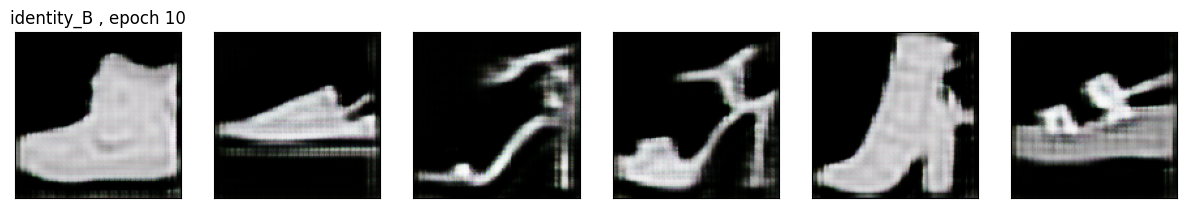

EPOCH  11
time  90.0 sec, processed images:  100
EPOCH  12
time  91.0 sec, processed images:  100
EPOCH  13
time  89.0 sec, processed images:  100
EPOCH  14
time  90.0 sec, processed images:  100
EPOCH  15
time  90.0 sec, processed images:  100


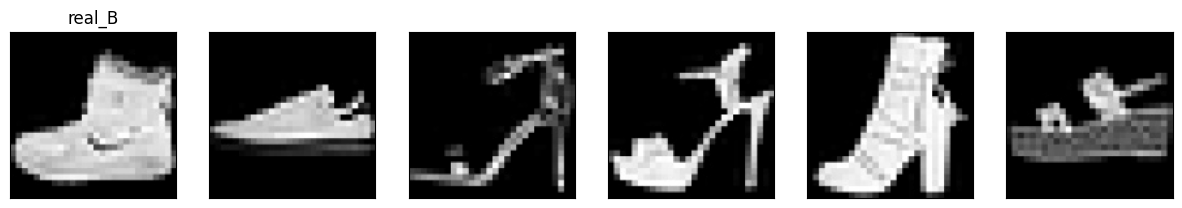

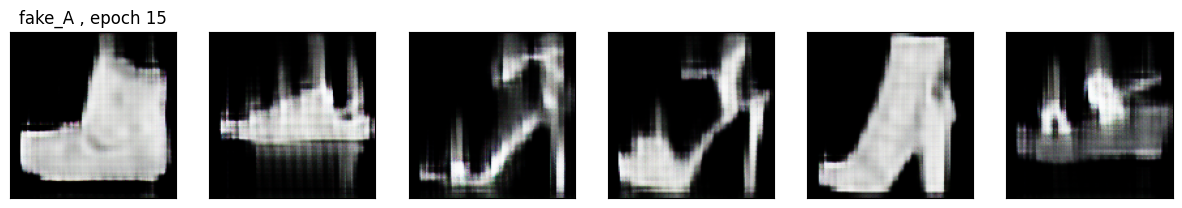

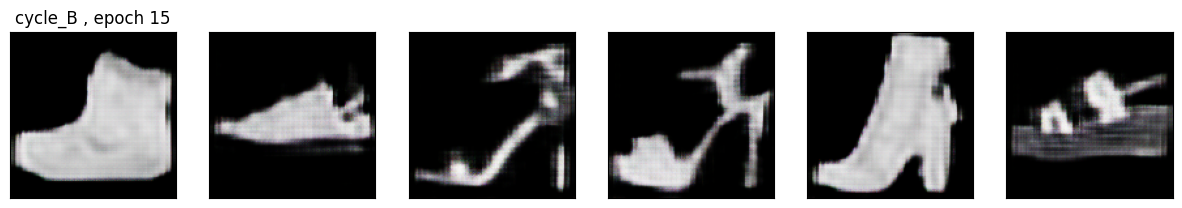

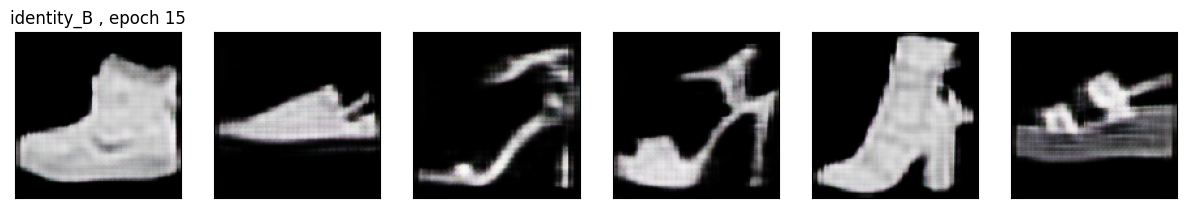

EPOCH  16
time  89.0 sec, processed images:  100
EPOCH  17
time  89.0 sec, processed images:  100
EPOCH  18
time  89.0 sec, processed images:  100
EPOCH  19
time  90.0 sec, processed images:  100
EPOCH  20
time  89.0 sec, processed images:  100


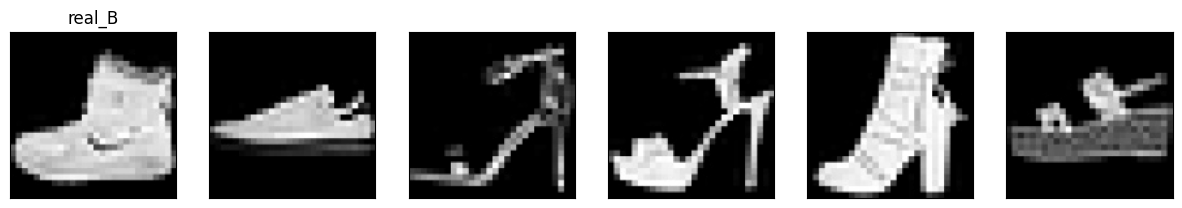

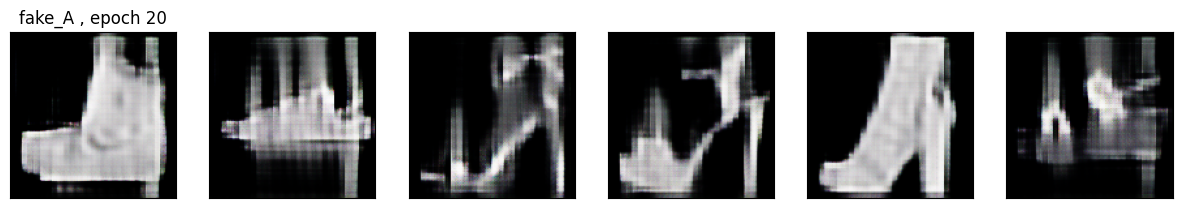

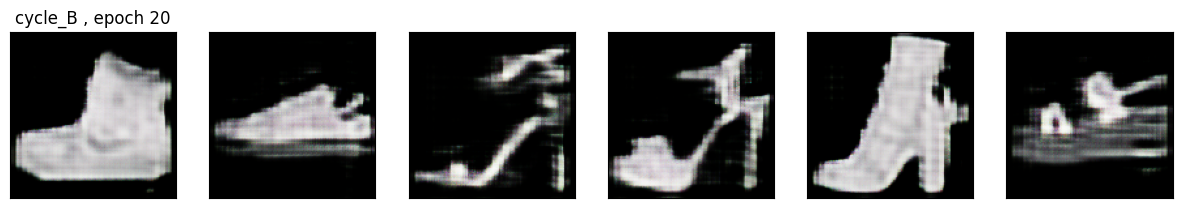

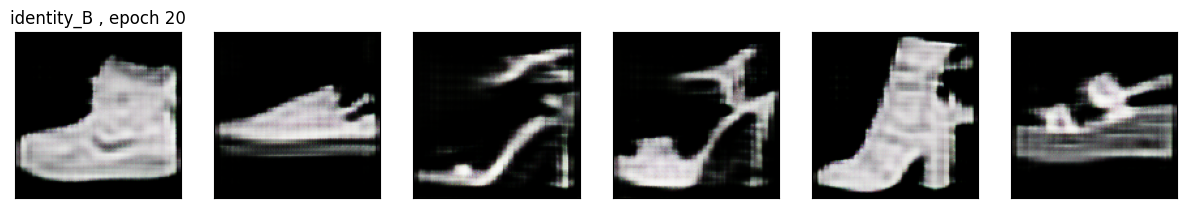

EPOCH  21
time  88.0 sec, processed images:  100
EPOCH  22
time  88.0 sec, processed images:  100
EPOCH  23
time  90.0 sec, processed images:  100
EPOCH  24
time  92.0 sec, processed images:  100
EPOCH  25
time  89.0 sec, processed images:  100


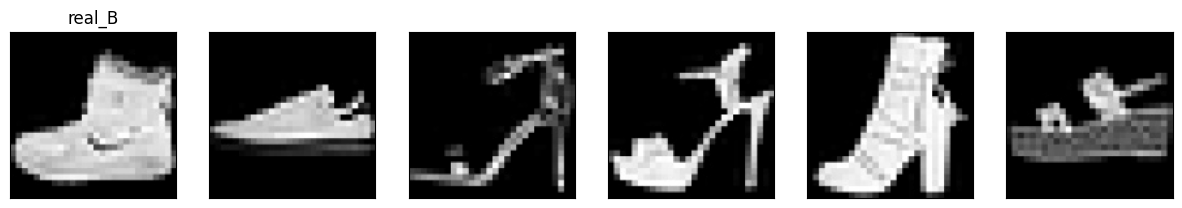

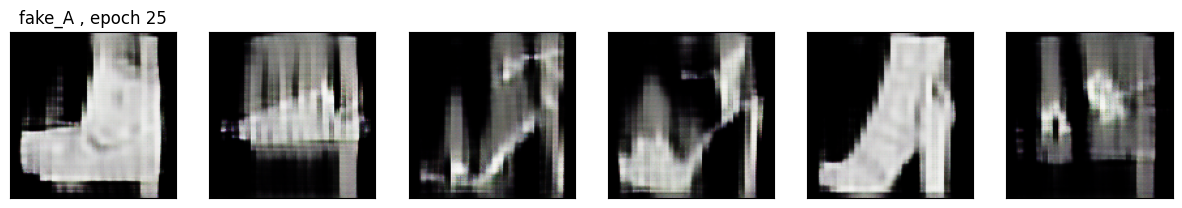

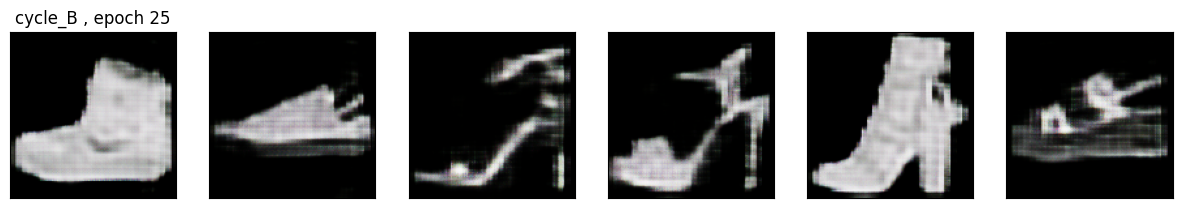

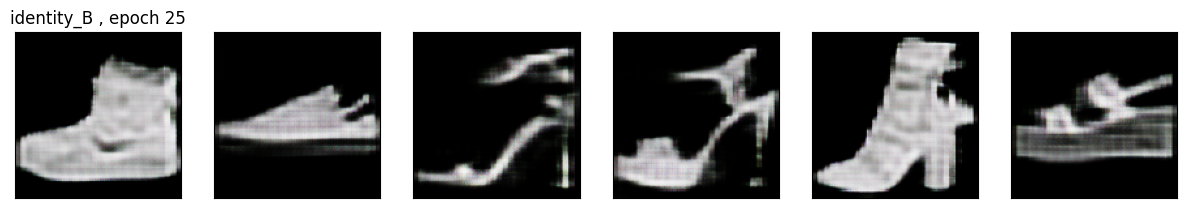

EPOCH  26
time  89.0 sec, processed images:  100
EPOCH  27
time  89.0 sec, processed images:  100
EPOCH  28
time  90.0 sec, processed images:  100
EPOCH  29
time  88.0 sec, processed images:  100


In [ ]:
def train(EPOCH, EPOCH_PREV):
    #цикл по всем эпохам
    for i in range(EPOCH):
        train_step(i + EPOCH_PREV) #вызываем функцию train_step для одного шага обучения на текущей эпохе

        #проверяем вывод каждые 5 эпох
        if (i + EPOCH_PREV) % 5 == 0:
            check_output(i + EPOCH_PREV) #вызываем функцию check_output для проверки и визуализации результатов на текущей эпохе

train(10, 0)
train(10, 10)
train(10, 20)

Код выбирает изображение с индексом `sample=881` из домена B (**Fashion MNIST**, классы 5–9), загружает его с помощью `read_img`, преобразует в формат [-1, 1] и размер (1, 128, 128, 3), генерирует изображение домена A (классы 0–4) с помощью генератора `gen_BA`, конвертирует результат в формат **uint8** для визуализации и отображает его с заголовком, используя **matplotlib**:

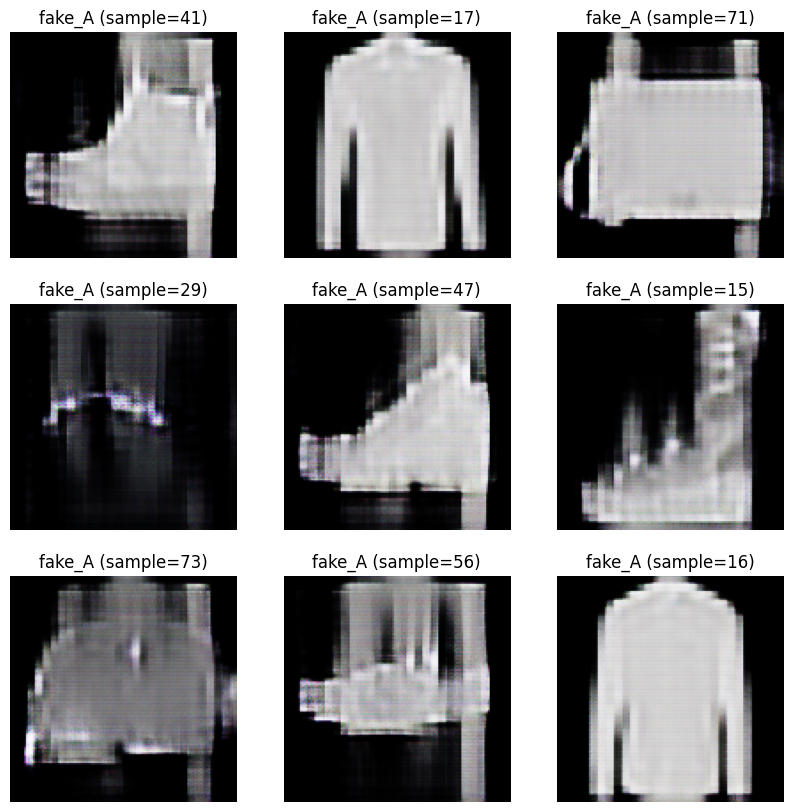

In [ ]:
samples = np.random.choice(n2, size=9, replace=False) #случайный выбор 9 уникальных индексов
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
#загружаем и нормализуем изображение из домена B, преобразуем в форму (1, 128, 128, 3)
for k in range(9):
    sample = samples[k]
    real_F = read_img(dir_B, files_B[sample], convert=True).reshape(1, 128, 128, 3)
    fake_A = np.array(gen_BA(real_F))[0] #генерируем изображение домена A из изображения домена B
    prediction = convert_img(fake_A).astype(np.uint8) #преобразуем сгенерированное изображение в формат uint8 для визуализации
    i = int(k / 3)
    j = k % 3
    ax[i, j].imshow(prediction)
    ax[i, j].set_title(f"fake_A (sample={sample})")
    ax[i, j].axis('off')
plt.show()